This project is based on kaggle's project - [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers)

Obejctive - Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers

The techniques used in here have been inspired and adapted from [Z2M machine learning course](https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-3-structured-data-projects/end-to-end-bluebook-bulldozer-price-regression.ipynb).

Most of the MarkDown cell are directly copied.

## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can see it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll use to tune HyperParameters).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

(Root Mean Squre vs Root Mean Squared Log Error)[https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a]

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

After downloading the dataset, I have stored it in the same folder in which this Jupyter Notebook is present

In [2]:
# Import the training and validation set
train_and_valid = pd.read_csv("TrainAndValid.csv")
train_and_valid.info()

C:\Users\Harshal Garg\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [3]:
train_and_valid = pd.read_csv("TrainAndValid.csv",
                             low_memory = False, #to avoid the error shown above
                             parse_dates = ["saledate"]) #to convert into date time, (see column index - 9)
train_and_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

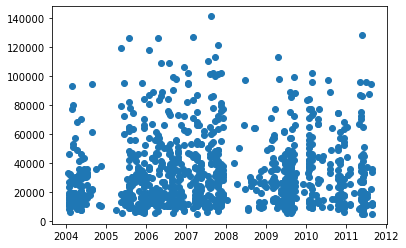

In [4]:
fig, ax = plt.subplots()
ax.scatter(train_and_valid["saledate"][:1000], train_and_valid["SalePrice"][:1000]);

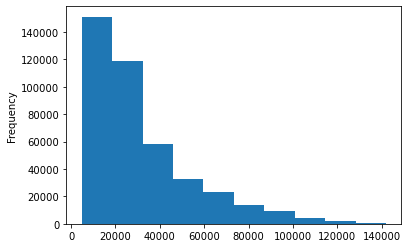

In [5]:
train_and_valid.SalePrice.plot.hist();

### Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a [datetime object](https://docs.python.org/3/library/datetime.html) (a Python data type which encodes specific information about dates).

In [6]:
train_and_valid.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_and_valid.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [8]:
train_and_valid.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame in tact if we need it again.

In [9]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = train_and_valid.copy()

### Add datetime parameters for saledate column

Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parase_dates=["saledate"]`, we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the `saledate` column.

In [10]:
#Add datetime paramter
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

#delete the old paramter
df_tmp.drop("saledate", inplace = True, axis = 1)

In [11]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


In [12]:
#state wise sales count
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

Why model so early?

We know the evaluation metric we're heading towards. We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA.

Remember, one of the biggest goals of starting any new machine learning project is reducing the time between experiments.

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we find a [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) might be a good candidate.

In [13]:
# # This won't work since we've got missing numbers and categories
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs=-1)
# model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

In [14]:
# Check for missing categories, different datatypes and missing values
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

## Convert strings to categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data.

In [15]:
pd.api.types.is_object_dtype(df_tmp["UsageBand"])

True

In [16]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

The columns and values of a DataFrame can be iterate like a dictionary as key and value respectively

In [17]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content): # this will select only string datatype
        df_tmp[label] = content.astype("category")#.cat.as_ordered()

In [18]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [19]:
# to see all the values in the "state" which is a category datatype
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [20]:
# to see the codes assigned to index
df_tmp.state.cat.codes 

0          0
1         32
2         31
3         43
4         31
          ..
412693    43
412694     8
412695     8
412696    43
412697     8
Length: 412698, dtype: int8

All of our data is categorical and thus we can now turn the categories into numbers, however it's still missing values...

In [21]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In the format it's in, it's still good to be worked with, let's save it to file and reimport it so we can continue on.

### Save Processed Data

In [22]:
# Save the processed data and reload it
df_tmp.to_csv("train_tmp.csv", index = False)
df_tmp = pd.read_csv("train_tmp.csv", low_memory = False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


Excellent, our processed DataFrame has the columns we added to it but it's still missing values.

In [23]:
# Check missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill missing values

From our experience with machine learning models. We know two things:
1. All of our data has to be numerical
2. There can't be any missing values

And as we've seen using `df_tmp.isna().sum()` our data still has plenty of missing values.

Let's fill them.

### Filling numerical values first

We're going to fill any column with missing values with the median of that column.

In [24]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content): #this will filter out the numeric datatype
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [25]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content): #this will filter out the numeric datatype
        if pd.isnull(content).any(): #printing the values which have null values
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [26]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).any():
               # Add a binary column which tells if the data was missing our not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())

In [27]:
df_tmp["auctioneerID_is_missing"].head()

0    False
1    False
2    False
3    False
4    False
Name: auctioneerID_is_missing, dtype: bool

Why add a binary column indicating whether the data was missing or not?  
We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

Another method to do this is using SimpleImputer from sklearn

In [28]:
# Check if there's any null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

### Filling and turning categorical variables to numbers

Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [29]:
# check columns which are not numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [30]:
#Turn categorical variable into numbers
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing values in any categorie as -1
        # this means the missing values will be automatically filled
        df_tmp[label] = pd.Categorical(content).codes + 1

In [31]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [32]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [33]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,True
Blade_Type_is_missing,True,True,True,True,True
Travel_Controls_is_missing,True,True,True,True,True
Differential_Type_is_missing,False,False,True,True,True


Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

We are not going to run this model as it will take a long time and it is not accurate

In [36]:
%%time
# Instantiate model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)
#CPU times: user 25min 34s, sys: 10.4 s, total: 25min 44s
#Wall time: 1min 49s

# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)
#Answer is -- 0.987621368497284

Wall time: 2min 51s


0.9875749770430892

**Question:** Why is this metric not reliable?

### Splitting data into train/valid sets

In [37]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,2,963,...,True,True,True,True,True,True,True,True,False,False
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,2,1745,...,True,True,True,True,True,True,True,True,False,False
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,1,336,...,True,True,True,True,True,True,True,True,True,True
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,1,3716,...,True,True,True,True,True,True,True,True,True,True
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,3,4261,...,True,True,True,True,True,True,True,True,True,True


According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like `train_test_split()` wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

In [38]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [39]:
# split the data into training and validation
df_valid = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

df_valid.shape, df_train.shape

((11573, 103), (401125, 103))

In [40]:
# split the data in X and y

X_train = df_train.drop("SalePrice", axis = 1)
y_train = df_train["SalePrice"]

X_valid = df_valid.drop("SalePrice", axis = 1)
y_valid = df_valid["SalePrice"]

### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

In [41]:
#create evaluation function (the competition uses root mean square log error)

from sklearn.metrics import mean_absolute_error, mean_squared_log_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

#create a function to get other values
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE" : mean_absolute_error(y_train, train_preds), 
              "Valid MAE" : mean_absolute_error(y_valid, val_preds),
              "Training RMSLE" : rmsle(y_train, train_preds),
              "Valid RMSLE" : rmsle(y_valid, val_preds),
              "Training R^2" : model.score(X_train, y_train), #default parameter 
              "Valid R^2" : model.score(X_valid, y_valid)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If you're experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [42]:
# This takes too long...

# %%time
# # Retrain a model on training data
# model.fit(X_train, y_train)
# show_scores(model)

In [43]:
X_train.shape

(401125, 102)

Depending on your computer (mine is a MacBook Pro), making calculations on ~400,000 rows may take a while...

Let's alter the number of samples each `n_estimator` in the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) see's using the `max_samples` parameter.

Setting `max_samples` to 10000 means every `n_estimator` (default 100) in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [44]:
# Change max samples in RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)

In [45]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

Wall time: 8.12 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [46]:
show_scores(model)

{'Training MAE': 5569.968438516671,
 'Valid MAE': 7198.053093407068,
 'Training RMSLE': 0.25807427483088874,
 'Valid RMSLE': 0.2939072046234083,
 'Training R^2': 0.8602105854927383,
 'Valid R^2': 0.8316162209563858}

Beautiful, that took far less time than the model with all the data.

With this, let's try tune some hyperparameters.

### Hyperparameter tuning with RandomizedSearchCV

You can increase `n_iter` to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.

Remember, we're trying to reduce the amount of time it takes between experiments.

In [47]:
%%time
from sklearn.model_selection import RandomizedSearchCV

#different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators" : np.arange(10, 100, 10), 
          "max_depth": [None, 3, 5, 10],
          "min_samples_split" : np.arange(2, 20, 2),
          "min_samples_leaf" : np.arange(1, 20, 2),
          "max_features" : [0.5, 1, "sqrt", "auto"],
          "max_samples" : [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions = rf_grid,
                              n_iter = 20,
                              n_jobs = -1,
                              cv = 5, 
                              verbose = True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


Wall time: 3min 25s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [48]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [49]:
show_scores(rs_model)

{'Training MAE': 5633.209523116063,
 'Valid MAE': 7221.171331562264,
 'Training RMSLE': 0.2604483470533907,
 'Valid RMSLE': 0.2947848270534946,
 'Training R^2': 0.8566562591008695,
 'Valid R^2': 0.8287834853318596}

In [50]:
%%time
# Most ideal hyperparameters
my_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=15,
                                    min_samples_split=12,
                                    max_features="auto",
                                    n_jobs=-1,
                                    max_samples=None)
my_model.fit(X_train, y_train)

show_scores(my_model)

Wall time: 2min 6s


{'Training MAE': 4100.000081031849,
 'Valid MAE': 6180.331506749122,
 'Training RMSLE': 0.19543840803950155,
 'Valid RMSLE': 0.25297440267024235,
 'Training R^2': 0.9186471599695936,
 'Valid R^2': 0.8664237096089161}

### Train a model with the best parameters

In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting n_iter to 100 in RandomizedSearchCV) and found the best results came from the ones you see below.

Note: This kind of search on my computer (n_iter = 100) took ~2-hours. So it's kind of a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the max_samples back to its original value.

In [51]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

Wall time: 1min 8s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [52]:
show_scores(ideal_model)

{'Training MAE': 2919.6225119740006,
 'Valid MAE': 5899.76795438675,
 'Training RMSLE': 0.14311592710455898,
 'Valid RMSLE': 0.24406792234150515,
 'Training R^2': 0.9599257577414527,
 'Valid R^2': 0.8840548597432827}

In [53]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

Wall time: 32.4 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

In [54]:
show_scores(fast_model)

{'Training MAE': 2546.372107605771,
 'Valid MAE': 5964.8145009481295,
 'Training RMSLE': 0.12951158080659264,
 'Valid RMSLE': 0.2448616713834809,
 'Training R^2': 0.967067628723917,
 'Valid R^2': 0.8800215130107379}


Make predictions on test data

Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.


In [55]:
df_test = pd.read_csv("Test.csv", parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [56]:
# # Let's see how the model goes predicting on the test data
# # This won't work as the data is not in the desired format
# model.predict(df_test)


In [57]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

**Question**: Where would this function break?

**Hint**: What if the test data had different missing values to the training data?

Now we've got a function for preprocessing data, let's preprocess the test dataset into the same format as our training dataset.


In [58]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


This will not work as the columns of processed test and train are different

In [59]:
# Make predictions on the test dataset using the best model
# test_preds = ideal_model.predict(df_test)

In [60]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1139246,999089,3157,121,3.0,2004,68.0,2,963,298,...,True,True,True,True,True,True,True,True,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1745,529,...,True,True,True,True,True,True,True,True,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,336,111,...,True,True,True,True,True,True,True,True,True,True
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3716,1381,...,True,True,True,True,True,True,True,True,True,True
4,1139253,1057373,17311,121,3.0,2007,722.0,3,4261,1538,...,True,True,True,True,True,True,True,True,True,True


In [61]:
#difference between the columns
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}



In this case, it's because the test dataset wasn't missing any auctioneerID fields.

To fix it, we'll add a column to the test dataset called auctioneerID_is_missing and fill it with False, since none of the auctioneerID fields are missing in the test dataset.


In [62]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [63]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)



When looking at the (Kaggle submission)[https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation] requirements, we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the SalesID and the predicted SalePrice of the bulldozer.

Let's make it.


In [64]:
df_preds = pd.DataFrame(data = [df_test["SalesID"].astype(int), test_preds], index = ["SalesID", "SalesPrice"])
df_preds = df_preds.T
df_preds.head()

,SalesID,SalesPrice
0,1227829.0,20848.187690
1,1227844.0,20304.820310
2,1227847.0,46917.086030
3,1227848.0,61483.029226
4,1227863.0,47603.317055


In [65]:
# Export to csv...
df_preds.to_csv("predictions.csv", index=False)


### Feature Importance

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Beware: the default feature importances for random forests can lead to non-ideal results.

To find which features were most important of a machine learning model, a good idea is to search something like "[MODEL NAME] feature importance".

Doing this for our RandomForestRegressor leads us to find the feature_importances_ attribute.

Let's check it out.


In [66]:
ideal_model.feature_importances_

array([3.21761234e-02, 1.82791721e-02, 4.20585875e-02, 1.71083099e-03,
       3.33760264e-03, 2.05587765e-01, 3.11007640e-03, 1.00844353e-03,
       4.38371868e-02, 4.55344340e-02, 6.27318940e-02, 4.92588055e-03,
       2.23346797e-02, 1.55489958e-01, 4.57441172e-02, 5.92433805e-03,
       2.19976518e-03, 4.08443342e-03, 3.10720035e-03, 5.00511857e-02,
       4.68872236e-04, 4.84369990e-05, 7.94200013e-04, 1.68471103e-04,
       1.37663515e-03, 2.28476689e-05, 2.01512503e-03, 6.16407846e-03,
       1.15039457e-03, 1.89947454e-03, 2.28582946e-03, 2.44039848e-03,
       4.15676267e-03, 1.31716508e-03, 1.50179353e-03, 1.82258934e-02,
       8.02484131e-04, 1.15439416e-02, 2.04943334e-03, 1.99378356e-03,
       1.57482594e-03, 9.35435607e-04, 2.11702328e-03, 5.56167517e-04,
       3.93311683e-04, 3.48222159e-04, 1.79273234e-04, 2.43610844e-03,
       8.17119946e-04, 3.62811776e-04, 8.43024846e-04, 7.38990911e-02,
       3.82255368e-03, 5.65541921e-03, 2.88971511e-03, 9.97180471e-03,
      

In [67]:
# more foramtted version
feature_importance = pd.DataFrame(data = [ideal_model.feature_importances_], 
                                  columns = df_test.columns, 
                                 index = ["features_importance"]).T\
                                .sort_values("features_importance",
                                               ascending = False)
    
feature_importance

,features_importance
YearMade,0.205588
ProductSize,0.155490
saleYear,0.073899
fiSecondaryDesc,0.062732
Enclosure,0.050051
...,...
fiBaseModel_is_missing,0.000000
fiSecondaryDesc_is_missing,0.000000
state_is_missing,0.000000
ProductGroup_is_missing,0.000000


In [68]:
feature_importance.index

Index(['YearMade', 'ProductSize', 'saleYear', 'fiSecondaryDesc', 'Enclosure',
       'fiProductClassDesc', 'fiBaseModel', 'fiModelDesc', 'ModelID',
       'SalesID',
       ...
       'Turbocharged', 'Forks_is_missing', 'Blade_Extension_is_missing',
       'Transmission_is_missing', 'Drive_System_is_missing',
       'fiBaseModel_is_missing', 'fiSecondaryDesc_is_missing',
       'state_is_missing', 'ProductGroup_is_missing',
       'ProductGroupDesc_is_missing'],
      dtype='object', length=102)

In [69]:
import seaborn as sns 

def plot_features(df, n = 20): # plot top 20 (be default) features
    
    sns.barplot(x = "features_importance",
                y = df.index[:n],
               data = df[:n],
               orient = 'h')

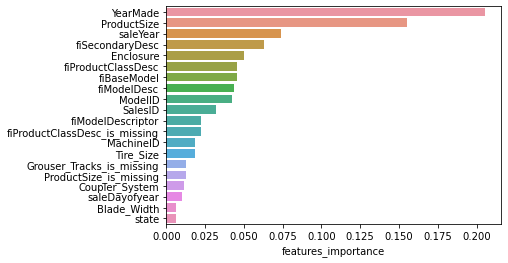

In [70]:

plot_features(feature_importance)
# plot_features(X_train.columns, ideal_model.feature_importances_)





**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

**Final challenge/extension:** What other machine learning models could you try on our dataset? **Hint:** https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.
